In [1]:
import os 
import numpy as np 
import cv2
import glob
import tensorflow as tf
from tqdm import tqdm
import tensorflow.keras as keras
from tensorflow.keras.models import Model
import re
import pydicom
from PIL import Image
import numpy as np
import dicom2jpg
import shutil




In [2]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def delete_all_files(folder_path):
    for root, dirs, files in os.walk(folder_path):
        for file_name in files:
            # Construct the full file path
            file_path = os.path.join(root, file_name)
            # Check if it's a file (not a directory)
            if os.path.isfile(file_path):
                # Delete the file
                os.remove(file_path)

    

    

In [3]:


inputdir = r'C:\Users\keanu\Profile\DEMO2.0\DICOMFIELS'
temp = 'temp'
#os.mkdir(outdir)
create_dir(temp)
delete_all_files(temp)

dicom2jpg.dicom2png(inputdir, temp) 

True

In [4]:




def find_and_copy_png_files(source_dir, destination_dir):
    # Walk through all directories and subdirectories in the source directory
    for root, dirs, files in os.walk(source_dir):
        for file in files:
            # Check if the file is a PNG file
            if file.lower().endswith('.png'):
                # Copy the PNG file to the destination directory
                shutil.copy2(os.path.join(root, file), destination_dir)

# Specify the source directory containing the folders
source_directory = temp

# Specify the destination directory to save the PNG files
outdir = "PNG_images"
create_dir(outdir)
# Call the function to find and copy PNG files
find_and_copy_png_files(source_directory, outdir)

print("PNG files copied successfully.")
delete_all_files(source_directory)

PNG files copied successfully.


In [5]:
items = os.listdir(inputdir)
first_item_path=""
if items:
    first_item = items[0]
    first_item_path = os.path.abspath(os.path.join(inputdir, first_item))
    first_item_path_raw = r"{}".format(first_item_path)
    print("Full path to the first item (raw string):", first_item_path_raw)
else:
    print("The folder is empty.")

Full path to the first item (raw string): C:\Users\keanu\Profile\DEMO2.0\DICOMFIELS\ADNI_002_S_0295_PT_ADNI_Brain_PET__Raw_FDG_br_raw_20110609102406227_49_S111104_I239487.dcm


In [6]:
dicom_file_path = first_item_path

# Read the DICOM file
dicom_data = pydicom.dcmread(dicom_file_path)

# Extract patient information
patient_info = {
    "Patient Name": dicom_data.get("PatientName", "N/A"),
    "Patient ID": dicom_data.get("PatientID", "N/A"),
    "Patient Birth Date": dicom_data.get("PatientBirthDate", "N/A"),
    "Patient Sex": dicom_data.get("PatientSex", "N/A"),
    "Patient Age": dicom_data.get("PatientAge", "N/A"),
    "Patient Weight": dicom_data.get("PatientWeight", "N/A"),
    "Patient Address": dicom_data.get("PatientAddress", "N/A"),
}

# Print patient information
for key, value in patient_info.items():
    print(f"{key}: {value}")

Patient Name: 002_S_0295
Patient ID: 002_S_0295
Patient Birth Date: N/A
Patient Sex: M
Patient Age: 089Y
Patient Weight: 70.760000
Patient Address: N/A


In [7]:
test_path=outdir
directory = test_path
import os
import re
def natural_sort_key(s):
    """ Sort string in a human-readable way, handling numbers correctly. """
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

# Get a list of all the png files in the directory
files = [f for f in os.listdir(directory) if f.endswith('.png')]
files.sort(key=natural_sort_key)

# Rename each file
for i, filename in enumerate(files):
    new_name = f"{i}.png"
    os.rename(os.path.join(directory, filename), os.path.join(directory, new_name))



In [8]:
dataset_path = os.path.join("dataset", "non-aug")
files_dir= os.path.join("files", "non-aug")
model_file=os.path.join(files_dir, "unet_FULL_BRAIN.h5")








create_dir(files_dir)

In [9]:
save_path= "prediction"
create_dir(save_path)
model2=tf.keras.models.load_model(model_file)
model2.summary()



Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

In [10]:

test_x=sorted(glob.glob(os.path.join(outdir,"*")))

print(len(test_x))
time_taken=[]
import time
for x in tqdm(test_x):
    name = x.split("/")[-1]

    
    # Read and preprocess the image
    x_img = cv2.imread(x, cv2.IMREAD_COLOR)
    if x_img is None:
        print(f"Failed to read image: {x}")
        continue
    x_img = x_img / 255.0
    x_img = np.expand_dims(x_img, axis=0)
    
    # Predict the output
    start_time = time.time()
    p = model2.predict(x_img)[0]
    total_time = time.time() - start_time
    time_taken.append(total_time)
    p = p > 0.5
    p = (p * 255).astype(np.uint8)  


    simplified_p = np.zeros_like(p)  # Create a simple image with the same shape
    simplified_save_path = os.path.join(save_path, f"simplified_{name}")
    simplified_success = cv2.imwrite(simplified_save_path, simplified_p)

    save_path_full = os.path.join(save_path, name)
    os.makedirs(os.path.dirname(save_path_full), exist_ok=True)
    
    success = cv2.imwrite(save_path_full, p)

216


  0%|          | 0/216 [00:00<?, ?it/s]

1/1 [==============================] - 0s 457ms/step


  0%|          | 1/216 [00:00<01:48,  1.97it/s]

1/1 [==============================] - 0s 135ms/step


  1%|          | 2/216 [00:00<01:05,  3.27it/s]

1/1 [==============================] - 0s 147ms/step


  1%|▏         | 3/216 [00:00<00:52,  4.06it/s]

1/1 [==============================] - 0s 130ms/step


  2%|▏         | 4/216 [00:01<00:44,  4.72it/s]

1/1 [==============================] - 0s 136ms/step


  2%|▏         | 5/216 [00:01<00:41,  5.12it/s]

1/1 [==============================] - 0s 137ms/step


  3%|▎         | 6/216 [00:01<00:38,  5.41it/s]

1/1 [==============================] - 0s 132ms/step


  3%|▎         | 7/216 [00:01<00:36,  5.66it/s]

1/1 [==============================] - 0s 136ms/step


  4%|▎         | 8/216 [00:01<00:36,  5.76it/s]

1/1 [==============================] - 0s 136ms/step


  4%|▍         | 9/216 [00:01<00:35,  5.84it/s]

1/1 [==============================] - 0s 127ms/step


  5%|▍         | 10/216 [00:01<00:34,  6.03it/s]

1/1 [==============================] - 0s 128ms/step


  5%|▌         | 11/216 [00:02<00:33,  6.14it/s]

1/1 [==============================] - 0s 129ms/step


  6%|▌         | 12/216 [00:02<00:32,  6.22it/s]

1/1 [==============================] - 0s 127ms/step


  6%|▌         | 13/216 [00:02<00:32,  6.29it/s]

1/1 [==============================] - 0s 141ms/step


  6%|▋         | 14/216 [00:02<00:32,  6.15it/s]

1/1 [==============================] - 0s 141ms/step


  7%|▋         | 15/216 [00:02<00:33,  6.09it/s]

1/1 [==============================] - 0s 132ms/step


  7%|▋         | 16/216 [00:02<00:32,  6.10it/s]

1/1 [==============================] - 0s 127ms/step


  8%|▊         | 17/216 [00:03<00:32,  6.20it/s]

1/1 [==============================] - 0s 128ms/step


  8%|▊         | 18/216 [00:03<00:31,  6.23it/s]

1/1 [==============================] - 0s 132ms/step


  9%|▉         | 19/216 [00:03<00:31,  6.22it/s]

1/1 [==============================] - 0s 135ms/step


  9%|▉         | 20/216 [00:03<00:31,  6.20it/s]

1/1 [==============================] - 0s 153ms/step


 10%|▉         | 21/216 [00:03<00:32,  5.97it/s]

1/1 [==============================] - 0s 135ms/step


 10%|█         | 22/216 [00:03<00:32,  6.00it/s]

1/1 [==============================] - 0s 134ms/step


 11%|█         | 23/216 [00:04<00:31,  6.06it/s]

1/1 [==============================] - 0s 134ms/step


 11%|█         | 24/216 [00:04<00:31,  6.07it/s]

1/1 [==============================] - 0s 132ms/step


 12%|█▏        | 25/216 [00:04<00:31,  6.12it/s]

1/1 [==============================] - 0s 135ms/step


 12%|█▏        | 26/216 [00:04<00:31,  6.12it/s]

1/1 [==============================] - 0s 153ms/step


 12%|█▎        | 27/216 [00:04<00:32,  5.88it/s]

1/1 [==============================] - 0s 133ms/step


 13%|█▎        | 28/216 [00:04<00:31,  5.92it/s]

1/1 [==============================] - 0s 127ms/step


 13%|█▎        | 29/216 [00:05<00:30,  6.08it/s]

1/1 [==============================] - 0s 126ms/step


 14%|█▍        | 30/216 [00:05<00:29,  6.20it/s]

1/1 [==============================] - 0s 126ms/step


 14%|█▍        | 31/216 [00:05<00:29,  6.30it/s]

1/1 [==============================] - 0s 135ms/step


 15%|█▍        | 32/216 [00:05<00:29,  6.23it/s]

1/1 [==============================] - 0s 140ms/step


 15%|█▌        | 33/216 [00:05<00:29,  6.14it/s]

1/1 [==============================] - 0s 130ms/step


 16%|█▌        | 34/216 [00:05<00:29,  6.13it/s]

1/1 [==============================] - 0s 133ms/step


 16%|█▌        | 35/216 [00:06<00:29,  6.14it/s]

1/1 [==============================] - 0s 127ms/step


 17%|█▋        | 36/216 [00:06<00:28,  6.22it/s]

1/1 [==============================] - 0s 129ms/step


 17%|█▋        | 37/216 [00:06<00:28,  6.23it/s]

1/1 [==============================] - 0s 164ms/step


 18%|█▊        | 38/216 [00:06<00:30,  5.86it/s]

1/1 [==============================] - 0s 142ms/step


 18%|█▊        | 39/216 [00:06<00:30,  5.84it/s]

1/1 [==============================] - 0s 133ms/step


 19%|█▊        | 40/216 [00:06<00:29,  5.92it/s]

1/1 [==============================] - 0s 126ms/step


 19%|█▉        | 41/216 [00:07<00:28,  6.06it/s]

1/1 [==============================] - 0s 135ms/step


 19%|█▉        | 42/216 [00:07<00:28,  6.07it/s]

1/1 [==============================] - 0s 131ms/step


 20%|█▉        | 43/216 [00:07<00:28,  6.12it/s]

1/1 [==============================] - 0s 131ms/step


 20%|██        | 44/216 [00:07<00:27,  6.18it/s]

1/1 [==============================] - 0s 151ms/step


 21%|██        | 45/216 [00:07<00:28,  5.97it/s]

1/1 [==============================] - 0s 135ms/step


 21%|██▏       | 46/216 [00:07<00:28,  6.01it/s]

1/1 [==============================] - 0s 129ms/step


 22%|██▏       | 47/216 [00:08<00:27,  6.07it/s]

1/1 [==============================] - 0s 127ms/step


 22%|██▏       | 48/216 [00:08<00:27,  6.17it/s]

1/1 [==============================] - 0s 131ms/step


 23%|██▎       | 49/216 [00:08<00:26,  6.20it/s]

1/1 [==============================] - 0s 134ms/step


 23%|██▎       | 50/216 [00:08<00:26,  6.19it/s]

1/1 [==============================] - 0s 143ms/step


 24%|██▎       | 51/216 [00:08<00:27,  6.06it/s]

1/1 [==============================] - 0s 145ms/step


 24%|██▍       | 52/216 [00:08<00:27,  5.95it/s]

1/1 [==============================] - 0s 131ms/step


 25%|██▍       | 53/216 [00:09<00:26,  6.05it/s]

1/1 [==============================] - 0s 129ms/step


 25%|██▌       | 54/216 [00:09<00:26,  6.14it/s]

1/1 [==============================] - 0s 135ms/step


 25%|██▌       | 55/216 [00:09<00:26,  6.13it/s]

1/1 [==============================] - 0s 131ms/step


 26%|██▌       | 56/216 [00:09<00:26,  6.14it/s]

1/1 [==============================] - 0s 137ms/step


 26%|██▋       | 57/216 [00:09<00:25,  6.12it/s]

1/1 [==============================] - 0s 136ms/step


 27%|██▋       | 58/216 [00:09<00:25,  6.09it/s]

1/1 [==============================] - 0s 127ms/step


 27%|██▋       | 59/216 [00:10<00:25,  6.20it/s]

1/1 [==============================] - 0s 134ms/step


 28%|██▊       | 60/216 [00:10<00:25,  6.19it/s]

1/1 [==============================] - 0s 134ms/step


 28%|██▊       | 61/216 [00:10<00:25,  6.19it/s]

1/1 [==============================] - 0s 139ms/step


 29%|██▊       | 62/216 [00:10<00:25,  6.11it/s]

1/1 [==============================] - 0s 137ms/step


 29%|██▉       | 63/216 [00:10<00:25,  6.06it/s]

1/1 [==============================] - 0s 181ms/step


 30%|██▉       | 64/216 [00:10<00:27,  5.61it/s]

1/1 [==============================] - 0s 128ms/step


 30%|███       | 65/216 [00:11<00:25,  5.81it/s]

1/1 [==============================] - 0s 132ms/step


 31%|███       | 66/216 [00:11<00:25,  5.88it/s]

1/1 [==============================] - 0s 126ms/step


 31%|███       | 67/216 [00:11<00:24,  6.06it/s]

1/1 [==============================] - 0s 126ms/step


 31%|███▏      | 68/216 [00:11<00:23,  6.19it/s]

1/1 [==============================] - 0s 138ms/step


 32%|███▏      | 69/216 [00:11<00:24,  6.12it/s]

1/1 [==============================] - 0s 133ms/step


 32%|███▏      | 70/216 [00:11<00:23,  6.15it/s]

1/1 [==============================] - 0s 129ms/step


 33%|███▎      | 71/216 [00:11<00:23,  6.20it/s]

1/1 [==============================] - 0s 134ms/step


 33%|███▎      | 72/216 [00:12<00:23,  6.21it/s]

1/1 [==============================] - 0s 130ms/step


 34%|███▍      | 73/216 [00:12<00:22,  6.24it/s]

1/1 [==============================] - 0s 125ms/step


 34%|███▍      | 74/216 [00:12<00:22,  6.33it/s]

1/1 [==============================] - 0s 141ms/step


 35%|███▍      | 75/216 [00:12<00:22,  6.18it/s]

1/1 [==============================] - 0s 152ms/step


 35%|███▌      | 76/216 [00:12<00:23,  5.89it/s]

1/1 [==============================] - 0s 156ms/step


 36%|███▌      | 77/216 [00:13<00:24,  5.69it/s]

1/1 [==============================] - 0s 159ms/step


 36%|███▌      | 78/216 [00:13<00:25,  5.50it/s]

1/1 [==============================] - 0s 187ms/step


 37%|███▋      | 79/216 [00:13<00:26,  5.16it/s]

1/1 [==============================] - 0s 150ms/step


 37%|███▋      | 80/216 [00:13<00:25,  5.25it/s]

1/1 [==============================] - 0s 143ms/step


 38%|███▊      | 81/216 [00:13<00:25,  5.35it/s]

1/1 [==============================] - 0s 130ms/step


 38%|███▊      | 82/216 [00:13<00:23,  5.59it/s]

1/1 [==============================] - 0s 126ms/step


 38%|███▊      | 83/216 [00:14<00:22,  5.83it/s]

1/1 [==============================] - 0s 126ms/step


 39%|███▉      | 84/216 [00:14<00:22,  5.97it/s]

1/1 [==============================] - 0s 129ms/step


 39%|███▉      | 85/216 [00:14<00:21,  6.04it/s]

1/1 [==============================] - 0s 146ms/step


 40%|███▉      | 86/216 [00:14<00:22,  5.90it/s]

1/1 [==============================] - 0s 143ms/step


 40%|████      | 87/216 [00:14<00:22,  5.86it/s]

1/1 [==============================] - 0s 135ms/step


 41%|████      | 88/216 [00:14<00:21,  5.92it/s]

1/1 [==============================] - 0s 140ms/step


 41%|████      | 89/216 [00:15<00:21,  5.88it/s]

1/1 [==============================] - 0s 135ms/step


 42%|████▏     | 90/216 [00:15<00:21,  5.91it/s]

1/1 [==============================] - 0s 178ms/step


 42%|████▏     | 91/216 [00:15<00:22,  5.56it/s]

1/1 [==============================] - 0s 146ms/step


 43%|████▎     | 92/216 [00:15<00:22,  5.58it/s]

1/1 [==============================] - 0s 155ms/step


 43%|████▎     | 93/216 [00:15<00:22,  5.51it/s]

1/1 [==============================] - 0s 141ms/step


 44%|████▎     | 94/216 [00:16<00:21,  5.62it/s]

1/1 [==============================] - 0s 128ms/step


 44%|████▍     | 95/216 [00:16<00:20,  5.79it/s]

1/1 [==============================] - 0s 142ms/step


 44%|████▍     | 96/216 [00:16<00:20,  5.76it/s]

1/1 [==============================] - 0s 130ms/step


 45%|████▍     | 97/216 [00:16<00:20,  5.91it/s]

1/1 [==============================] - 0s 141ms/step


 45%|████▌     | 98/216 [00:16<00:19,  5.90it/s]

1/1 [==============================] - 0s 142ms/step


 46%|████▌     | 99/216 [00:16<00:19,  5.86it/s]

1/1 [==============================] - 0s 146ms/step


 46%|████▋     | 100/216 [00:17<00:20,  5.76it/s]

1/1 [==============================] - 0s 143ms/step


 47%|████▋     | 101/216 [00:17<00:20,  5.74it/s]

1/1 [==============================] - 0s 136ms/step


 47%|████▋     | 102/216 [00:17<00:19,  5.85it/s]

1/1 [==============================] - 0s 133ms/step


 48%|████▊     | 103/216 [00:17<00:19,  5.89it/s]

1/1 [==============================] - 0s 156ms/step


 48%|████▊     | 104/216 [00:17<00:19,  5.69it/s]

1/1 [==============================] - 0s 181ms/step


 49%|████▊     | 105/216 [00:17<00:21,  5.24it/s]

1/1 [==============================] - 0s 136ms/step


 49%|████▉     | 106/216 [00:18<00:20,  5.44it/s]

1/1 [==============================] - 0s 131ms/step


 50%|████▉     | 107/216 [00:18<00:19,  5.63it/s]

1/1 [==============================] - 0s 144ms/step


 50%|█████     | 108/216 [00:18<00:19,  5.68it/s]

1/1 [==============================] - 0s 141ms/step


 50%|█████     | 109/216 [00:18<00:18,  5.74it/s]

1/1 [==============================] - 0s 141ms/step


 51%|█████     | 110/216 [00:18<00:18,  5.73it/s]

1/1 [==============================] - 0s 143ms/step


 51%|█████▏    | 111/216 [00:18<00:18,  5.75it/s]

1/1 [==============================] - 0s 142ms/step


 52%|█████▏    | 112/216 [00:19<00:18,  5.76it/s]

1/1 [==============================] - 0s 144ms/step


 52%|█████▏    | 113/216 [00:19<00:17,  5.73it/s]

1/1 [==============================] - 0s 130ms/step


 53%|█████▎    | 114/216 [00:19<00:17,  5.85it/s]

1/1 [==============================] - 0s 145ms/step


 53%|█████▎    | 115/216 [00:19<00:17,  5.83it/s]

1/1 [==============================] - 0s 146ms/step


 54%|█████▎    | 116/216 [00:19<00:17,  5.72it/s]

1/1 [==============================] - 0s 136ms/step


 54%|█████▍    | 117/216 [00:20<00:17,  5.82it/s]

1/1 [==============================] - 0s 129ms/step


 55%|█████▍    | 118/216 [00:20<00:16,  5.95it/s]

1/1 [==============================] - 0s 130ms/step


 55%|█████▌    | 119/216 [00:20<00:16,  6.01it/s]

1/1 [==============================] - 0s 134ms/step


 56%|█████▌    | 120/216 [00:20<00:15,  6.07it/s]

1/1 [==============================] - 0s 141ms/step


 56%|█████▌    | 121/216 [00:20<00:15,  6.01it/s]

1/1 [==============================] - 0s 168ms/step


 56%|█████▋    | 122/216 [00:20<00:16,  5.67it/s]

1/1 [==============================] - 0s 135ms/step


 57%|█████▋    | 123/216 [00:21<00:16,  5.69it/s]

1/1 [==============================] - 0s 131ms/step


 57%|█████▋    | 124/216 [00:21<00:15,  5.82it/s]

1/1 [==============================] - 0s 128ms/step


 58%|█████▊    | 125/216 [00:21<00:15,  5.97it/s]

1/1 [==============================] - 0s 133ms/step


 58%|█████▊    | 126/216 [00:21<00:14,  6.01it/s]

1/1 [==============================] - 0s 140ms/step


 59%|█████▉    | 127/216 [00:21<00:14,  5.98it/s]

1/1 [==============================] - 0s 136ms/step


 59%|█████▉    | 128/216 [00:21<00:14,  5.98it/s]

1/1 [==============================] - 0s 132ms/step


 60%|█████▉    | 129/216 [00:22<00:14,  6.06it/s]

1/1 [==============================] - 0s 146ms/step


 60%|██████    | 130/216 [00:22<00:14,  5.93it/s]

1/1 [==============================] - 0s 130ms/step


 61%|██████    | 131/216 [00:22<00:14,  6.05it/s]

1/1 [==============================] - 0s 131ms/step


 61%|██████    | 132/216 [00:22<00:13,  6.12it/s]

1/1 [==============================] - 0s 145ms/step


 62%|██████▏   | 133/216 [00:22<00:13,  5.95it/s]

1/1 [==============================] - 0s 139ms/step


 62%|██████▏   | 134/216 [00:22<00:13,  5.94it/s]

1/1 [==============================] - 0s 134ms/step


 62%|██████▎   | 135/216 [00:23<00:13,  6.02it/s]

1/1 [==============================] - 0s 170ms/step


 63%|██████▎   | 136/216 [00:23<00:14,  5.69it/s]

1/1 [==============================] - 0s 136ms/step


 63%|██████▎   | 137/216 [00:23<00:13,  5.80it/s]

1/1 [==============================] - 0s 134ms/step


 64%|██████▍   | 138/216 [00:23<00:13,  5.89it/s]

1/1 [==============================] - 0s 147ms/step


 64%|██████▍   | 139/216 [00:23<00:13,  5.85it/s]

1/1 [==============================] - 0s 144ms/step


 65%|██████▍   | 140/216 [00:23<00:13,  5.83it/s]

1/1 [==============================] - 0s 134ms/step


 65%|██████▌   | 141/216 [00:24<00:12,  5.93it/s]

1/1 [==============================] - 0s 142ms/step


 66%|██████▌   | 142/216 [00:24<00:12,  5.92it/s]

1/1 [==============================] - 0s 152ms/step


 66%|██████▌   | 143/216 [00:24<00:12,  5.73it/s]

1/1 [==============================] - 0s 157ms/step


 67%|██████▋   | 144/216 [00:24<00:12,  5.61it/s]

1/1 [==============================] - 0s 133ms/step


 67%|██████▋   | 145/216 [00:24<00:12,  5.74it/s]

1/1 [==============================] - 0s 134ms/step


 68%|██████▊   | 146/216 [00:24<00:12,  5.81it/s]

1/1 [==============================] - 0s 145ms/step


 68%|██████▊   | 147/216 [00:25<00:11,  5.82it/s]

1/1 [==============================] - 0s 132ms/step


 69%|██████▊   | 148/216 [00:25<00:11,  5.94it/s]

1/1 [==============================] - 0s 135ms/step


 69%|██████▉   | 149/216 [00:25<00:11,  5.98it/s]

1/1 [==============================] - 0s 129ms/step


 69%|██████▉   | 150/216 [00:25<00:10,  6.10it/s]

1/1 [==============================] - 0s 128ms/step


 70%|██████▉   | 151/216 [00:25<00:10,  6.20it/s]

1/1 [==============================] - 0s 150ms/step


 70%|███████   | 152/216 [00:25<00:10,  5.84it/s]

1/1 [==============================] - 0s 127ms/step


 71%|███████   | 153/216 [00:26<00:10,  6.01it/s]

1/1 [==============================] - 0s 130ms/step


 71%|███████▏  | 154/216 [00:26<00:10,  6.12it/s]

1/1 [==============================] - 0s 133ms/step


 72%|███████▏  | 155/216 [00:26<00:09,  6.16it/s]

1/1 [==============================] - 0s 134ms/step


 72%|███████▏  | 156/216 [00:26<00:09,  6.17it/s]

1/1 [==============================] - 0s 128ms/step


 73%|███████▎  | 157/216 [00:26<00:09,  6.20it/s]

1/1 [==============================] - 0s 126ms/step


 73%|███████▎  | 158/216 [00:26<00:09,  6.29it/s]

1/1 [==============================] - 0s 129ms/step


 74%|███████▎  | 159/216 [00:27<00:09,  6.31it/s]

1/1 [==============================] - 0s 133ms/step


 74%|███████▍  | 160/216 [00:27<00:08,  6.28it/s]

1/1 [==============================] - 0s 137ms/step


 75%|███████▍  | 161/216 [00:27<00:08,  6.18it/s]

1/1 [==============================] - 0s 133ms/step


 75%|███████▌  | 162/216 [00:27<00:08,  6.18it/s]

1/1 [==============================] - 0s 131ms/step


 75%|███████▌  | 163/216 [00:27<00:08,  6.22it/s]

1/1 [==============================] - 0s 134ms/step


 76%|███████▌  | 164/216 [00:27<00:08,  6.20it/s]

1/1 [==============================] - 0s 130ms/step


 76%|███████▋  | 165/216 [00:28<00:08,  6.24it/s]

1/1 [==============================] - 0s 145ms/step


 77%|███████▋  | 166/216 [00:28<00:08,  6.11it/s]

1/1 [==============================] - 0s 167ms/step


 77%|███████▋  | 167/216 [00:28<00:08,  5.79it/s]

1/1 [==============================] - 0s 129ms/step


 78%|███████▊  | 168/216 [00:28<00:08,  5.90it/s]

1/1 [==============================] - 0s 128ms/step


 78%|███████▊  | 169/216 [00:28<00:07,  6.02it/s]

1/1 [==============================] - 0s 130ms/step


 79%|███████▊  | 170/216 [00:28<00:07,  6.12it/s]

1/1 [==============================] - 0s 128ms/step


 79%|███████▉  | 171/216 [00:29<00:07,  6.22it/s]

1/1 [==============================] - 0s 138ms/step


 80%|███████▉  | 172/216 [00:29<00:07,  6.12it/s]

1/1 [==============================] - 0s 128ms/step


 80%|████████  | 173/216 [00:29<00:06,  6.21it/s]

1/1 [==============================] - 0s 132ms/step


 81%|████████  | 174/216 [00:29<00:06,  6.20it/s]

1/1 [==============================] - 0s 132ms/step


 81%|████████  | 175/216 [00:29<00:06,  6.24it/s]

1/1 [==============================] - 0s 135ms/step


 81%|████████▏ | 176/216 [00:29<00:06,  6.20it/s]

1/1 [==============================] - 0s 134ms/step


 82%|████████▏ | 177/216 [00:29<00:06,  6.22it/s]

1/1 [==============================] - 0s 136ms/step


 82%|████████▏ | 178/216 [00:30<00:06,  6.19it/s]

1/1 [==============================] - 0s 131ms/step


 83%|████████▎ | 179/216 [00:30<00:05,  6.22it/s]

1/1 [==============================] - 0s 133ms/step


 83%|████████▎ | 180/216 [00:30<00:05,  6.21it/s]

1/1 [==============================] - 0s 127ms/step


 84%|████████▍ | 181/216 [00:30<00:05,  6.23it/s]

1/1 [==============================] - 0s 169ms/step


 84%|████████▍ | 182/216 [00:30<00:05,  5.82it/s]

1/1 [==============================] - 0s 146ms/step


 85%|████████▍ | 183/216 [00:30<00:05,  5.79it/s]

1/1 [==============================] - 0s 134ms/step


 85%|████████▌ | 184/216 [00:31<00:05,  5.89it/s]

1/1 [==============================] - 0s 127ms/step


 86%|████████▌ | 185/216 [00:31<00:05,  6.02it/s]

1/1 [==============================] - 0s 132ms/step


 86%|████████▌ | 186/216 [00:31<00:04,  6.11it/s]

1/1 [==============================] - 0s 133ms/step


 87%|████████▋ | 187/216 [00:31<00:04,  6.12it/s]

1/1 [==============================] - 0s 131ms/step


 87%|████████▋ | 188/216 [00:31<00:04,  6.19it/s]

1/1 [==============================] - 0s 132ms/step


 88%|████████▊ | 189/216 [00:31<00:04,  6.23it/s]

1/1 [==============================] - 0s 135ms/step


 88%|████████▊ | 190/216 [00:32<00:04,  6.21it/s]

1/1 [==============================] - 0s 134ms/step


 88%|████████▊ | 191/216 [00:32<00:04,  6.17it/s]

1/1 [==============================] - 0s 129ms/step


 89%|████████▉ | 192/216 [00:32<00:03,  6.24it/s]

1/1 [==============================] - 0s 133ms/step


 89%|████████▉ | 193/216 [00:32<00:03,  6.24it/s]

1/1 [==============================] - 0s 176ms/step


 90%|████████▉ | 194/216 [00:32<00:03,  5.77it/s]

1/1 [==============================] - 0s 133ms/step


 90%|█████████ | 195/216 [00:32<00:03,  5.89it/s]

1/1 [==============================] - 0s 133ms/step


 91%|█████████ | 196/216 [00:33<00:03,  6.00it/s]

1/1 [==============================] - 0s 131ms/step


 91%|█████████ | 197/216 [00:33<00:03,  6.08it/s]

1/1 [==============================] - 0s 142ms/step


 92%|█████████▏| 198/216 [00:33<00:02,  6.04it/s]

1/1 [==============================] - 0s 135ms/step


 92%|█████████▏| 199/216 [00:33<00:02,  6.07it/s]

1/1 [==============================] - 0s 128ms/step


 93%|█████████▎| 200/216 [00:33<00:02,  6.13it/s]

1/1 [==============================] - 0s 133ms/step


 93%|█████████▎| 201/216 [00:33<00:02,  6.17it/s]

1/1 [==============================] - 0s 131ms/step


 94%|█████████▎| 202/216 [00:34<00:02,  6.19it/s]

1/1 [==============================] - 0s 135ms/step


 94%|█████████▍| 203/216 [00:34<00:02,  6.17it/s]

1/1 [==============================] - 0s 129ms/step


 94%|█████████▍| 204/216 [00:34<00:01,  6.23it/s]

1/1 [==============================] - 0s 132ms/step


 95%|█████████▍| 205/216 [00:34<00:01,  6.24it/s]

1/1 [==============================] - 0s 172ms/step


 95%|█████████▌| 206/216 [00:34<00:01,  5.78it/s]

1/1 [==============================] - 0s 136ms/step


 96%|█████████▌| 207/216 [00:34<00:01,  5.86it/s]

1/1 [==============================] - 0s 131ms/step


 96%|█████████▋| 208/216 [00:35<00:01,  5.97it/s]

1/1 [==============================] - 0s 128ms/step


 97%|█████████▋| 209/216 [00:35<00:01,  6.09it/s]

1/1 [==============================] - 0s 131ms/step


 97%|█████████▋| 210/216 [00:35<00:00,  6.08it/s]

1/1 [==============================] - 0s 146ms/step


 98%|█████████▊| 211/216 [00:35<00:00,  5.98it/s]

1/1 [==============================] - 0s 132ms/step


 98%|█████████▊| 212/216 [00:35<00:00,  6.07it/s]

1/1 [==============================] - 0s 134ms/step


 99%|█████████▊| 213/216 [00:35<00:00,  6.13it/s]

1/1 [==============================] - 0s 133ms/step


 99%|█████████▉| 214/216 [00:36<00:00,  6.16it/s]

1/1 [==============================] - 0s 134ms/step


100%|█████████▉| 215/216 [00:36<00:00,  6.18it/s]

1/1 [==============================] - 0s 132ms/step


100%|██████████| 216/216 [00:36<00:00,  5.94it/s]


In [11]:
test_image = np.zeros((128, 128, 1), dtype=np.uint8)
test_image_path = os.path.join(save_path, "test_image.png")
if cv2.imwrite(test_image_path, test_image):
    print("Successfully wrote test image")
else:
    print("Failed to write test image")

Successfully wrote test image


In [12]:
import os
from PIL import Image

def composite_images(image_folder, mask_folder, output_folder):
    # Get the list of image files in the input folder
    image_files = os.listdir(image_folder)
    
    # Iterate through each image file
    for image_file in image_files:
        # Construct the file paths for the current image and its corresponding mask
        image_path = os.path.join(image_folder, image_file)
        mask_file = image_file.split('.')[0] + '.png'  # Assuming masks have the same filename format as images
        mask_path = os.path.join(mask_folder, mask_file)
        
        # Open the image and mask
        image = Image.open(image_path)
        mask = Image.open(mask_path)
        
        # Perform composite operation
        result = Image.composite(image, Image.new('RGB', image.size, (0, 0, 0)), mask)
        
        # Construct the output file path
        output_file = os.path.join(output_folder, image_file)
        
        # Save the resulting composite image
        result.save(output_file)

# Paths to input image and mask folders, and output folder
image_folder = test_path


mask_folder  = save_path+ "\PNG_images"
output_folder= os.path.join("segmentation")


# Call the function to composite images and masks and save the results
composite_images(image_folder, mask_folder, output_folder)

In [13]:
#image = cv2.imread('/home/keanuf/.cache/Assignemt9/BRAIN SEGMENTATION/FULL_BRAIN/prediction,non-aug/50.png', cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded successfully
#if image is None:
  #  print("Error: Unable to load image!")
#else:
    # Count the number of white pixels (where pixel value is 255)
   # white_pixel_count = cv2.countNonZero(image)

    # Print the result
   # print(f"Number of white pixels: {white_pixel_count}")

#image = cv2.imread('/home/keanuf/.cache/Assignemt9/BRAIN SEGMENTATION/FULL_BRAIN/Segmented Images/50.png', cv2.IMREAD_GRAYSCALE)
# Check if the image was loaded successfully
#if image is None:
  #  print("Error: Unable to load image!")
#else:
    # Calculate the total value of all pixels across all channels
   #total_value = np.sum(image)

    # Print the result
   # print(f"Total value of all pixels: {total_value}")


#print("Average Pixel Intensity =",total_value/ white_pixel_count)


In [14]:
import os
import re
import cv2

area_array = []
png_arra = []
total_value= []
image_directory = mask_folder
# Get all filenames in the directory
filenames = os.listdir(image_directory)
# Sort filenames using regular expressions to sort numerically
sorted_filenames = sorted(filenames, key=lambda x: int(re.findall(r'\d+', x)[0]))

for filename in sorted_filenames:
    file_path = os.path.join(image_directory, filename)
    png_arra.append(file_path)
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    white_pixel_count = cv2.countNonZero(image)
    area_array.append(white_pixel_count)



image_directory = output_folder
# Get all filenames in the directory
filenames = os.listdir(image_directory)
# Sort filenames using regular expressions to sort numerically
sorted_filenames = sorted(filenames, key=lambda x: int(re.findall(r'\d+', x)[0]))

for filename in sorted_filenames:
    file_path = os.path.join(image_directory, filename)
    png_arra.append(file_path)
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    total = np.sum(image)
    total_value.append(total)

#print(area_array, len(area_array))
#print(total_value, len(total_value))
#print(png_arra, len(png_arra))

array1= np.array(area_array)
array2=np.array(total_value)

print("Shape of array1:", array1.shape)
print("Shape of array2:", array2.shape)
result = np.where(array2 != 0,  array2/array1 , 0)

areas=array1

Shape of array1: (216,)
Shape of array2: (216,)


C:\Users\keanu\AppData\Local\Temp\ipykernel_17832\3388074107.py:45: RuntimeWarning: invalid value encountered in divide
  result = np.where(array2 != 0,  array2/array1 , 0)


In [15]:
print(result)

[  0.           0.           0.         153.4102228  146.69824891
 130.15028727 127.60691897 104.64079293 144.084      142.45652174
 110.         141.29166667   0.           0.         126.43620178
 173.9808978  129.98480786 138.33273756 107.7262024  138.72470978
 146.62352462 145.21721677 105.74371859 178.           0.
 125.03435115 161.0706383  141.71956145 135.92687386 145.36260828
 132.37262714 125.65186047 116.3633829  132.32419734 132.9781759
 129.85307156 137.11363636 155.5        169.66666667   0.
   0.         113.23553719 169.32370433 117.32761373 135.67638791
 131.76397516 133.30601596 132.64124436 130.33788314 130.16300069
 137.33004178 144.47845601 136.07692308 149.71112477   0.
 128.7690387  157.77671958 157.42940746 138.95410628 144.76381547
 122.73449248 144.15909748 140.63578757 147.54334301 138.81870229
 107.95238095 105.38447972 119.87837838 123.51054217 137.40317023
 142.47110965 144.38387097 130.59194566 123.90978311 107.80598456
 141.74685205 141.23300699 147.6671

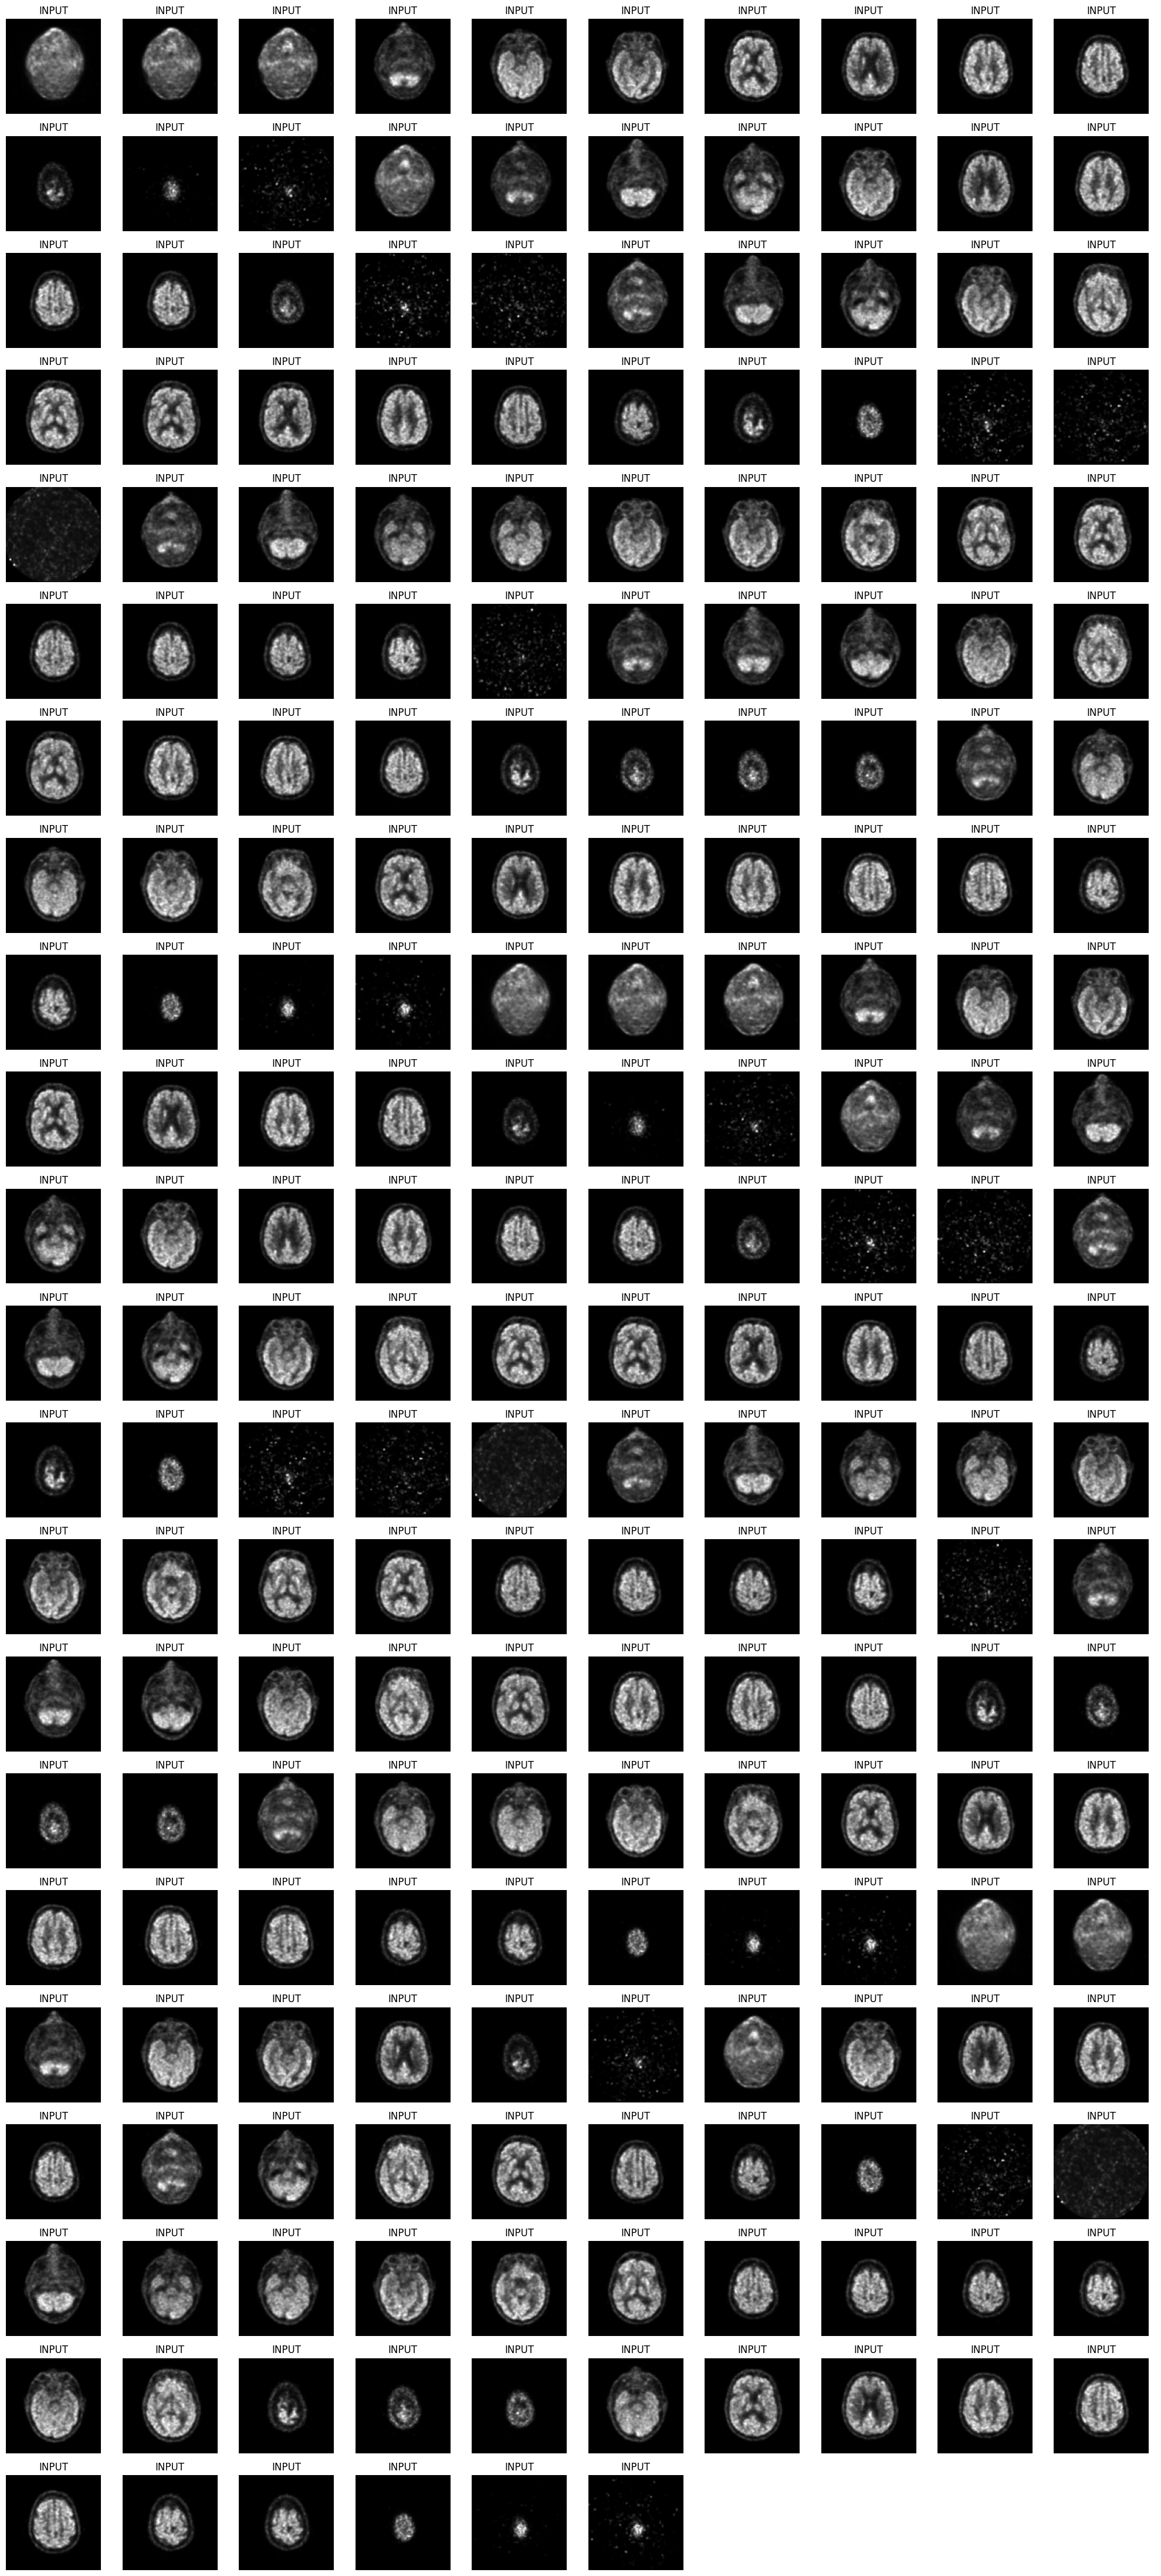

In [16]:
import matplotlib.pyplot as plt
import math
image_directory = test_path
 # Array containing titles corresponding to each image
# Get all filenames in the directory
filenames = os.listdir(image_directory)
# Sort filenames using regular expressions to sort numerically
sorted_filenames = sorted(filenames, key=lambda x: int(re.findall(r'\d+', x)[0]))

num_images = len(sorted_filenames)
num_cols = 10  # Number of columns
num_rows = math.ceil(num_images / num_cols)  # Calculate the number of rows needed

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, num_rows * 2))  # Dynamic figsize based on num_rows

for ax_row, row_index in zip(axes, range(num_rows)):
    for ax, filename in zip(ax_row, sorted_filenames[row_index * num_cols:]):
        file_path = os.path.join(image_directory, filename)
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        ax.imshow(image, cmap='gray')
        ax.set_title("INPUT")  # Set title from the results array
        ax.axis('off')  # Turn off axis

# Hide empty subplots if any
for i in range(num_images, num_rows * num_cols):
    axes.flatten()[i].axis('off')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()



Patient Name: 002_S_0295
Patient ID: 002_S_0295
Patient Birth Date: N/A
Patient Sex: M
Patient Age: 089Y
Patient Weight: 70.760000
Patient Address: N/A


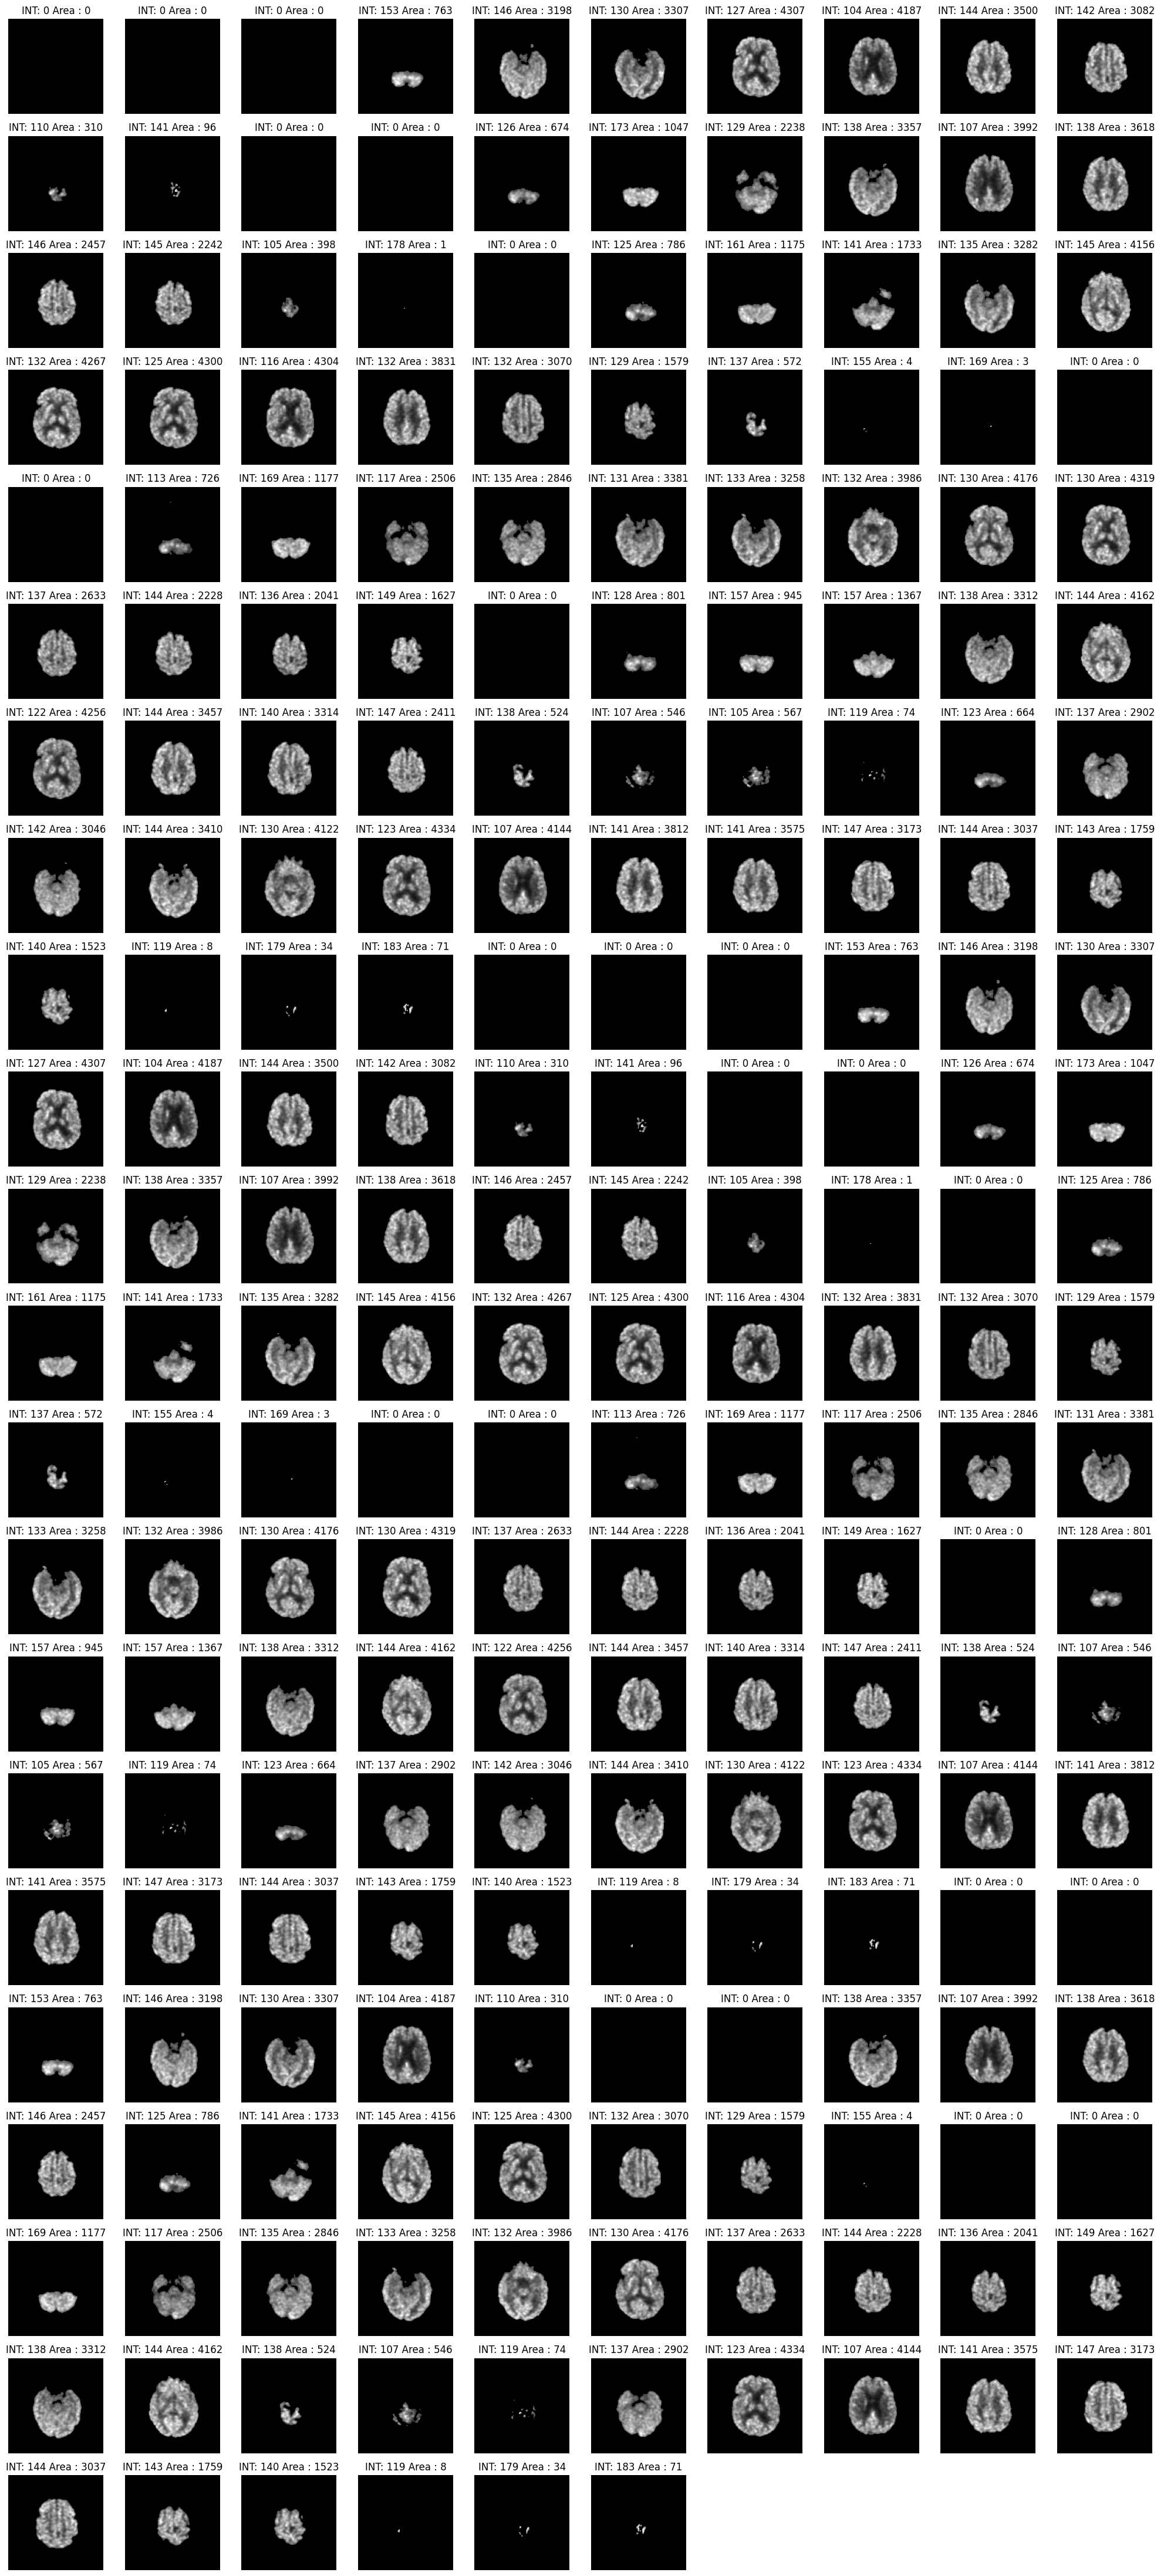

In [17]:
import matplotlib.pyplot as plt
import math
delete_all_files(outdir)
for key, value in patient_info.items():
    print(f"{key}: {value}")

image_directory = output_folder
 # Array containing titles corresponding to each image
# Get all filenames in the directory
filenames = os.listdir(image_directory)
# Sort filenames using regular expressions to sort numerically
sorted_filenames = sorted(filenames, key=lambda x: int(re.findall(r'\d+', x)[0]))

num_images = len(sorted_filenames)
num_cols = 10  # Number of columns
num_rows = math.ceil(num_images / num_cols)  # Calculate the number of rows needed

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, num_rows * 2))  # Dynamic figsize based on num_rows

for ax_row, row_index in zip(axes, range(num_rows)):
    for ax, filename, intentsity, area in zip(ax_row, sorted_filenames[row_index * num_cols:], result[row_index * num_cols:], areas[row_index * num_cols:]):
        file_path = os.path.join(image_directory, filename)
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        ax.imshow(image, cmap='gray')
        ax.set_title("INT: "+str(int(intentsity))+ " Area : " +str(int(area)))  # Set title from the results array
        ax.axis('off')  # Turn off axis

# Hide empty subplots if any
for i in range(num_images, num_rows * num_cols):
    axes.flatten()[i].axis('off')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

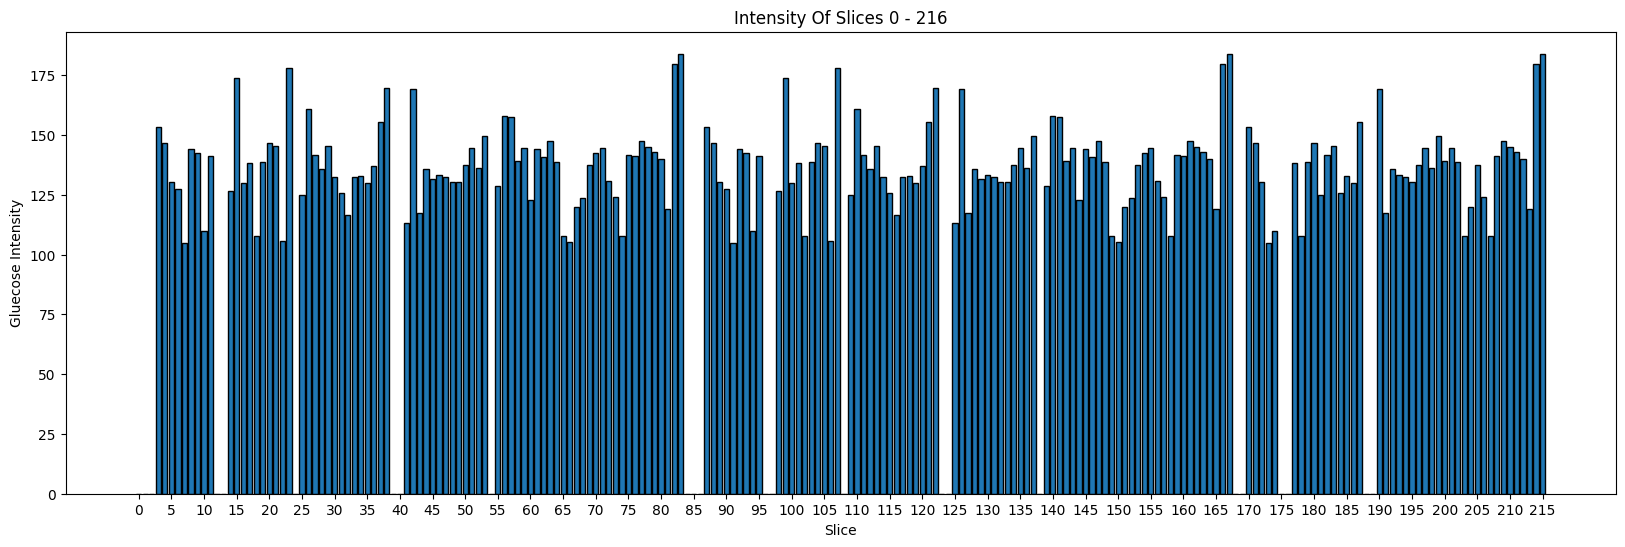

In [18]:

import matplotlib.pyplot as plt

def plot_histogram(data):
    plt.figure(figsize=(20, 6))  # Adjust the width and height of the figure as needed
    plt.bar(range(len(data)), data, align='center', edgecolor='black')
    plt.xlabel('Slice')
    plt.ylabel('Gluecose Intensity')
    plt.title('Intensity Of Slices 0 - '+str(len(data)))
    plt.xticks(range(0, len(data), 5))  # Set ticks at increments of 10
    plt.grid(False)
    plt.show()

# Example array with over 100 values
array = list(range(100))

plot_histogram(result)



# Specify the folder path


# Call the function to delete all files in the specified folder
delete_all_files(save_path)

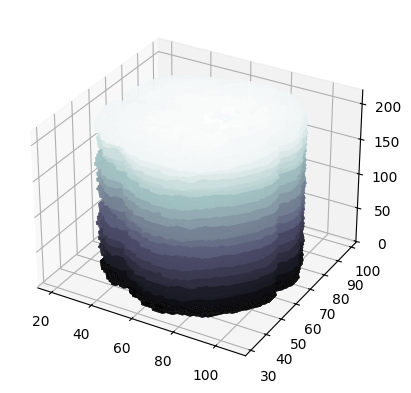

In [19]:
import skimage.io as io
import skimage.measure as measure
import os
import re
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
def load_images(directory):
    # Function to extract numerical index from the filename
    def extract_index(filename):
        match = re.search(r'(\d+)', filename)
        return int(match.group(1)) if match else -1

    # Sort files based on the extracted numerical index
    files = sorted(
        [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.png')],
        key=lambda x: extract_index(os.path.basename(x))
    )
    
    images = [io.imread(file, as_gray=True) for file in files]
    volume = np.stack(images, axis=-1)
    return volume

def segment_brain(volume, percentile=90):
    threshold = np.percentile(volume, percentile)
    segmented = volume > threshold
    return segmented.astype(np.float32)
def natural_sort_key(s):
    """ Sort string in a human-readable way, handling numbers correctly. """
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def rename_directory(directory_path):


    # Define the directory where your images are located
    directory = directory_path



    # Get a list of all the png files in the directory
    files = [f for f in os.listdir(directory) if f.endswith('.png')]

    # Sort the files by name, using natural sort
    files.sort(key=natural_sort_key)

    # Rename each file
    for i, filename in enumerate(files):
        new_name = f"{i}.png"
        os.rename(os.path.join(directory, filename), os.path.join(directory, new_name))

    return directory_path
    

def plot_3d(verts, faces):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2], cmap='bone', lw=1)
    plt.show()

def extract_surface(volume, level=0.5):
    verts, faces, normals, values = measure.marching_cubes(volume, level=level)
    return verts, faces

def write_obj(filename, verts, faces):
    with open(filename, 'w') as file:
        for v in verts:
            file.write(f"v {v[0]} {v[1]} {v[2]}\n")
        for face in faces:
            file.write("f {} {} {}\n".format(face[0] + 1, face[1] + 1, face[2] + 1))

#threshold = int(input("Input Threshold: "))


volume = load_images(rename_directory(output_folder))
segmented_volume = segment_brain(volume, 90)
verts, faces = extract_surface(segmented_volume)
plot_3d(verts, faces)
write_obj("output_brain_model.obj", verts, faces)




In [20]:



delete_all_files(mask_folder)
delete_all_files(output_folder)
